- Secondary Dataset: [Property Valuation and Assessment Data](https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i/about_data)

- Geospatial Data: [NYC Neighborhoods](https://data.dathere.com/dataset/nyc-neighborhoods)


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# import plotly.graph_objects as go
%matplotlib inline

In [49]:
data = pd.read_csv('/Users/yu-shenglee/Desktop/folder/data/Property_Valuation_and_Assessment_Data_20241126.csv')
data.head()

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,VALTYPE,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA,New Georeferenced Column
0,1000163859,1,16,3859,NaN,"CHEN, QI TOM",R4,2,0,0,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000730028,1,73,28,NaN,NYC DSBS,V1,4,183,52,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000730029,1,73,29,NaN,NYC DSBS,Y7,4,90,500,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000297504,1,29,7504,NaN,NaN,R0,2,36,73,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000360012,1,36,12,NaN,NYC DSBS,Y7,4,534,604,...,AC-TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

1. Only keep 2018/19 data because:
    - 2018/19 has the most data points
    - the value is the most up-to-date
2. Remove data points where latitude and longitude are absent.
    - Latitude and Longitude both have 35,639 (~3%) null valeus. Removing them won't affect much.
    - Make easier to plot data on the map afterwwards.

In [50]:
# Rename column names
data.columns = [column.lower().replace(' ','_') for column in data.columns]
# Only include 2018/19 data
properties = data[data['year'] == '2018/19']
# Keep necessary columns
properties = properties[[
    'bble', 'boro', 'block', 'lot', 'bldgcl',
    'taxclass', 'stories', 'fullval', 'avland','avtot',
    'staddr', 'postcode', 'period', 'year', 'borough', 
    'latitude', 'longitude', 'council_district','nta']]
# Remove null longitude and latitude records
properties = properties[properties['longitude'].isnull()==False]

print(f'Before Clean: {data.shape[0]} rows\n After clean: {properties.shape[0]} rows\n')

Before Clean: 9845857 rows
 After clean: 1080953 rows



# Exploring Different Shapefiles to use

Borough Boundaries - only break NYC to the borough level. Not granular enough

<Axes: >

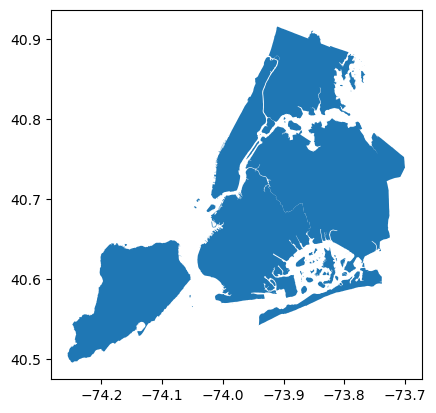

In [59]:
nyc_boro = gpd.read_file('/Users/yu-shenglee/Desktop/folder/data/Borough Boundaries/geo_export_44c5c250-510c-4467-8d13-0a9f8eff5d03.shp')
nyc_boro.plot()

Building level is too granular

<Axes: >

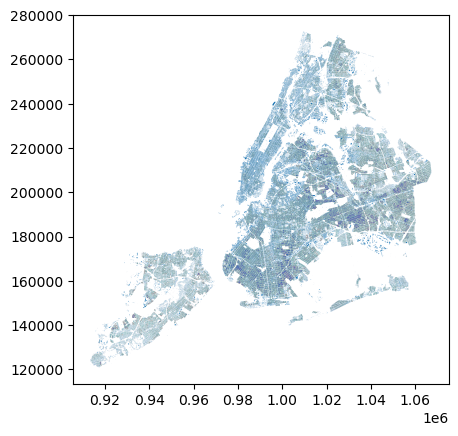

In [60]:
nyc_buildings = gpd.read_file('/Users/yu-shenglee/Desktop/folder/data/building_footprints_shape/building_0716.shp')
nyc_buildings.plot()

Finally, decided to use the neighborhood geojson file

<Axes: >

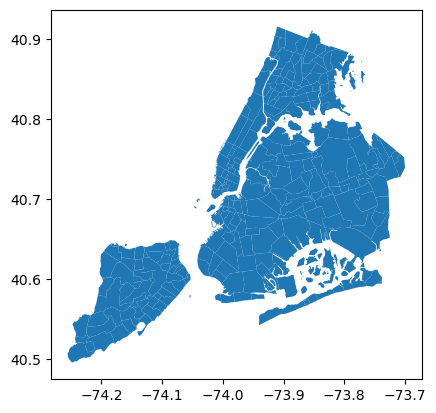

In [52]:
nyc_neighborhoods = gpd.read_file('/Users/yu-shenglee/Desktop/folder/data/nyc_neighborhoods.geojson')
nyc_neighborhoods.plot()


# Join the property data with neighborhood data
- Steps:
    1. Convert longitude and latitude to Point pair in a new column points
    2. And convert this data frame with new column points into a GeoPandas data frame
    3. Join nyc_neighborhoods with properties - nyc_neighborhoods has polygon as its geometry and geo_data1819 has point, so we can take all of our properties and attach them to the neighborhoods they are inside of using `Spatial Join`

In [53]:
# Convert longitude and latitude to Point pair in a new column points
points = properties.apply(lambda row: Point(row.longitude, row.latitude), axis = 1)

# Convert this data frame with new column points into a GeoPandas data frame
geo_properties = gpd.GeoDataFrame(properties, geometry=points)

# Tell GeoPandas that points column actually means (longitude, latitude) pair
# Use the same crs assumption as nyc_neighborhoods does
geo_properties.crs = {'init': str(nyc_neighborhoods.crs)}

# Join properties and nyc_neighborhoods based on neighborhoods
properties_w_neighborhoods = gpd.sjoin(geo_properties, nyc_neighborhoods, how='inner', predicate="within")

/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/c9/wtcfhbsj4_ggwscrqd_3_rpw0000gn/T/ipykernel_85824/1384916598.py:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  properties_w_neighborhoods = gpd.sjoin(geo_properties, nyc_neighborhoods, how='inner', predicate="within")


In [54]:
properties_by_neighborhoods = properties_w_neighborhoods[['fullval', 'neighborhood']]
properties_by_neighborhoods = properties_by_neighborhoods[properties_by_neighborhoods['fullval']>0]
properties_by_neighborhoods = properties_by_neighborhoods.groupby(properties_by_neighborhoods.neighborhood)

average_neighborhood_val = properties_by_neighborhoods.mean().merge(nyc_neighborhoods[['neighborhood','geometry']], how = 'left', on='neighborhood')
average_neighborhood_val = gpd.GeoDataFrame(average_neighborhood_val, geometry='geometry').rename(columns={'fullval':'avg_property_val'})
average_neighborhood_val['log_avg_property_val'] = np.log(average_neighborhood_val['avg_property_val'])
average_neighborhood_val['text'] = average_neighborhood_val['neighborhood'] + ':' + average_neighborhood_val['avg_property_val'].apply(lambda x: f"{int(x):,}").astype(str)
average_neighborhood_val.sort_values(by='avg_property_val')

,neighborhood,avg_property_val,geometry,log_avg_property_val,text
130,Hoffman Island,1.730000e+05,"POLYGON ((-74.05293 40.5799, -74.05314 40.5777...",12.061047,"Hoffman Island:173,000"
197,Parkchester,1.818979e+05,"POLYGON ((-73.85166 40.8342, -73.85906 40.8334...",12.111201,"Parkchester:181,897"
207,Pelham Islands,3.460000e+05,"POLYGON ((-73.78288 40.86241, -73.78315 40.862...",12.754194,"Pelham Islands:346,000"
211,Pelham Islands,3.460000e+05,"POLYGON ((-73.76669 40.8671, -73.7671 40.8667,...",12.754194,"Pelham Islands:346,000"
204,Pelham Islands,3.460000e+05,"POLYGON ((-73.80222 40.84163, -73.80264 40.841...",12.754194,"Pelham Islands:346,000"
...,...,...,...,...,...
227,Randall's Island,6.292967e+07,"POLYGON ((-73.92134 40.80085, -73.92103 40.800...",17.957528,"Randall's Island:62,929,666"
101,Floyd Bennett Field,1.194248e+08,"POLYGON ((-73.88398 40.60557, -73.88337 40.605...",18.598198,"Floyd Bennett Field:119,424,833"
89,Ellis Island,2.556780e+08,"POLYGON ((-74.04166 40.69645, -74.04367 40.698...",19.359429,"Ellis Island:255,678,000"
115,Governors Island,3.689830e+08,"POLYGON ((-74.02306 40.68292, -74.02319 40.683...",19.726261,"Governors Island:368,983,000"


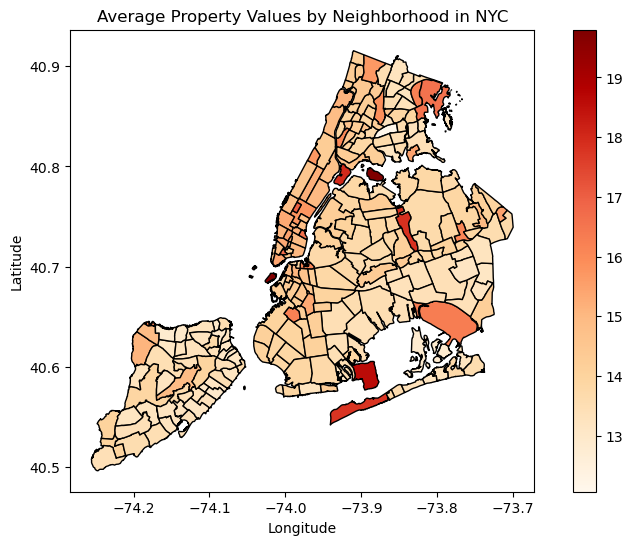

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

average_neighborhood_val.plot(
    column='log_avg_property_val',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='black',    
    vmin=average_neighborhood_val.log_avg_property_val.describe()['min'],
    vmax=average_neighborhood_val.log_avg_property_val.describe()['max'],
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
    })

plt.title('Average Property Values by Neighborhood in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()